# Задача 1. RMSNorm

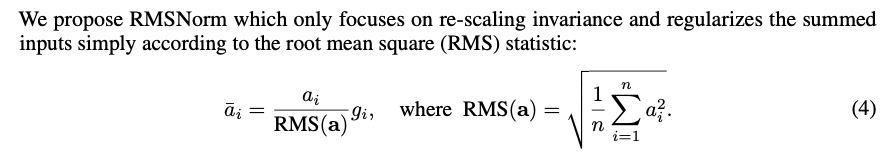

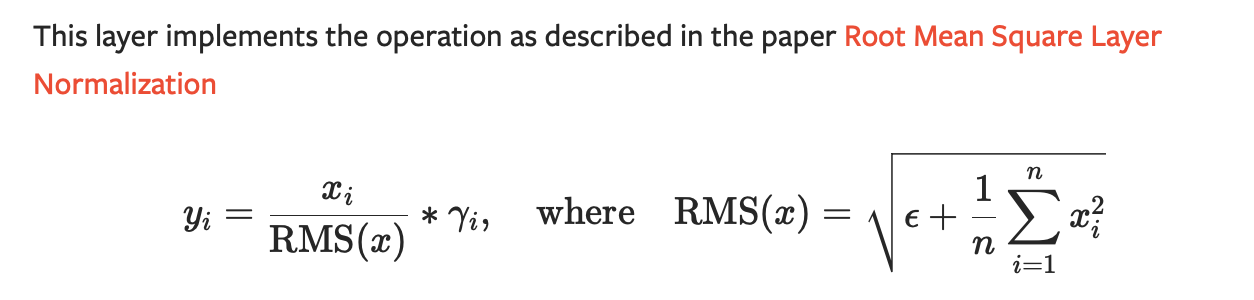

In [3]:
import torch
from torch import nn

In [43]:
class RMSNorm(nn.Module):
    def __init__(self, num_features: int, eps: float):
        super().__init__()

        self.num_features = num_features
        self.eps = eps

        self.gamma = nn.Parameter(torch.empty((num_features,), dtype=torch.float32), requires_grad=True)
        nn.init.ones_(self.gamma)

    def forward(self, x: torch.Tensor):

        rms = torch.sqrt((x ** 2).mean(dim=-1, keepdim=True) + self.eps)
        x_norm = x / rms
        return x_norm * self.gamma


In [44]:
test = torch.randn((4, 256), dtype=torch.float32) * 10

In [45]:
rms = RMSNorm(256, eps=1e-5)
print(rms(test))

tensor([[-1.3506,  0.4255, -0.2640,  ..., -1.1330, -1.3305, -0.0649],
        [ 1.3032,  0.0177, -0.3780,  ..., -0.8816,  0.1629, -0.1696],
        [ 0.2563,  2.5275,  0.5528,  ..., -1.2310, -0.5632,  1.8664],
        [-0.1999,  1.4649, -0.7872,  ...,  1.3059, -0.4281,  0.4158]],
       grad_fn=<MulBackward0>)


In [46]:
rms_nn = nn.RMSNorm(256, eps=1e-5)
print(rms_nn(test))

tensor([[-1.3506,  0.4255, -0.2640,  ..., -1.1330, -1.3305, -0.0649],
        [ 1.3032,  0.0177, -0.3780,  ..., -0.8816,  0.1629, -0.1696],
        [ 0.2563,  2.5275,  0.5528,  ..., -1.2310, -0.5632,  1.8664],
        [-0.1999,  1.4649, -0.7872,  ...,  1.3059, -0.4281,  0.4158]],
       grad_fn=<MulBackward0>)


# Задача 2. AutoGrad

In [73]:
# f = e^X + cos(Y)

In [90]:
from typing import Any, Tuple

import torch
import math

In [91]:
def compute_grad_torch():
    torch.manual_seed(42)
    x = torch.randn((15, 10), dtype=torch.float32, requires_grad=True)
    y = torch.randn((15, 10), dtype=torch.float32, requires_grad=True)

    # autorag op
    f = torch.exp(x) + torch.cos(y)
    # autograd op end

    loss = f.sum(dim=0).var(dim=0)
    loss.backward()
    return x.grad, y.grad

In [92]:
class MyFun(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, y: torch.Tensor):
        ctx.save_for_backward(x, y)
        return torch.exp(x) + torch.cos(y)

    @staticmethod
    def backward(ctx: Any, grad_output_f: torch.Tensor) -> Tuple[torch.Tensor, ...]:
        # given dL/df
        # need to compute dL/dx, dL/dy
        x, y = ctx.saved_tensors
        grad_x = torch.exp(x) * grad_output_f
        grad_y = -torch.sin(y) * grad_output_f
        return grad_x, grad_y



def my_fun(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
    return MyFun.apply(x, y)


def compute_grad_custom():
    torch.manual_seed(42)
    x = torch.randn((15, 10), dtype=torch.float32, requires_grad=True)
    y = torch.randn((15, 10), dtype=torch.float32, requires_grad=True)

    # autorag op
    f = my_fun(x, y)
    # autograd op end

    loss = f.sum(dim=0).var(dim=0)
    loss.backward()
    return x.grad, y.grad


In [96]:
gradx_torch, grady_torch = compute_grad_torch()
gradx_custom, grady_custom = compute_grad_custom()

print('gradx')
print(gradx_torch)
print(gradx_custom)
print('grady')
print(grady_torch)
print(grady_custom)

assert torch.allclose(gradx_custom, gradx_torch, atol=0.00001)
assert torch.allclose(grady_custom, grady_torch, atol=0.00001)

gradx
tensor([[-10.2612,   7.3155,  -5.5655,   0.1427,  -0.4761,   0.4453,   1.8352,
          -0.2782,  -0.3485,  -0.7856],
        [ -1.0090,   0.4062,  -1.0920,   0.6699,  -0.1120,   3.2802,   9.8999,
          -1.1802,  -0.4496,  -0.2345],
        [ -0.7000,   4.8599,  -5.0363,   6.2926,  -0.8681,   5.5951,   3.5278,
          -5.2596,  -0.5864,  -0.1575],
        [ -1.1617,   3.9062,  -0.5662,   0.4904,  -0.1932,   8.5235,   2.6355,
          -0.9056,  -1.0036,  -0.0696],
        [ -0.3147,   4.4743,  -0.9381,   0.6425,  -0.0676,  12.7848,   0.5574,
          -0.8499,  -0.2964,  -0.0782],
        [ -1.6152,   2.7969,  -1.3880,   3.8579,  -0.1070,   0.7331,   0.4709,
          -1.4352,  -0.6938,  -0.2969],
        [ -1.3548,  10.4573,  -0.6917,   4.6753,  -1.0248,   3.6034,  17.6067,
          -2.3361,  -1.0456,  -0.1240],
        [ -0.5204,   5.9340,  -1.9035,   1.9789,  -0.2556,   2.3438,   3.4049,
          -0.7288,  -0.0814,  -0.0713],
        [ -1.5103,   1.1782,  -0.5917,   0

# Задача 3. Lion

In [ ]:
# def train(weight, gradient, momentum, lr):

#     update = interp(gradient, momentum, β1) momentum = m0
#     update = np.sign(update)
#     momentum = interp(gradient, momentum, β2)

#     weight_decay = weight * λ

#     update = update + weight_decay
#     update = update * lr

#     return update, momentum

# interp(x, y, a) - линейная интерполяция (1 - a) * x + a * y
# sign - операции знака: 1 если положительное число, 0 если 0, -1 если отрицательное число.

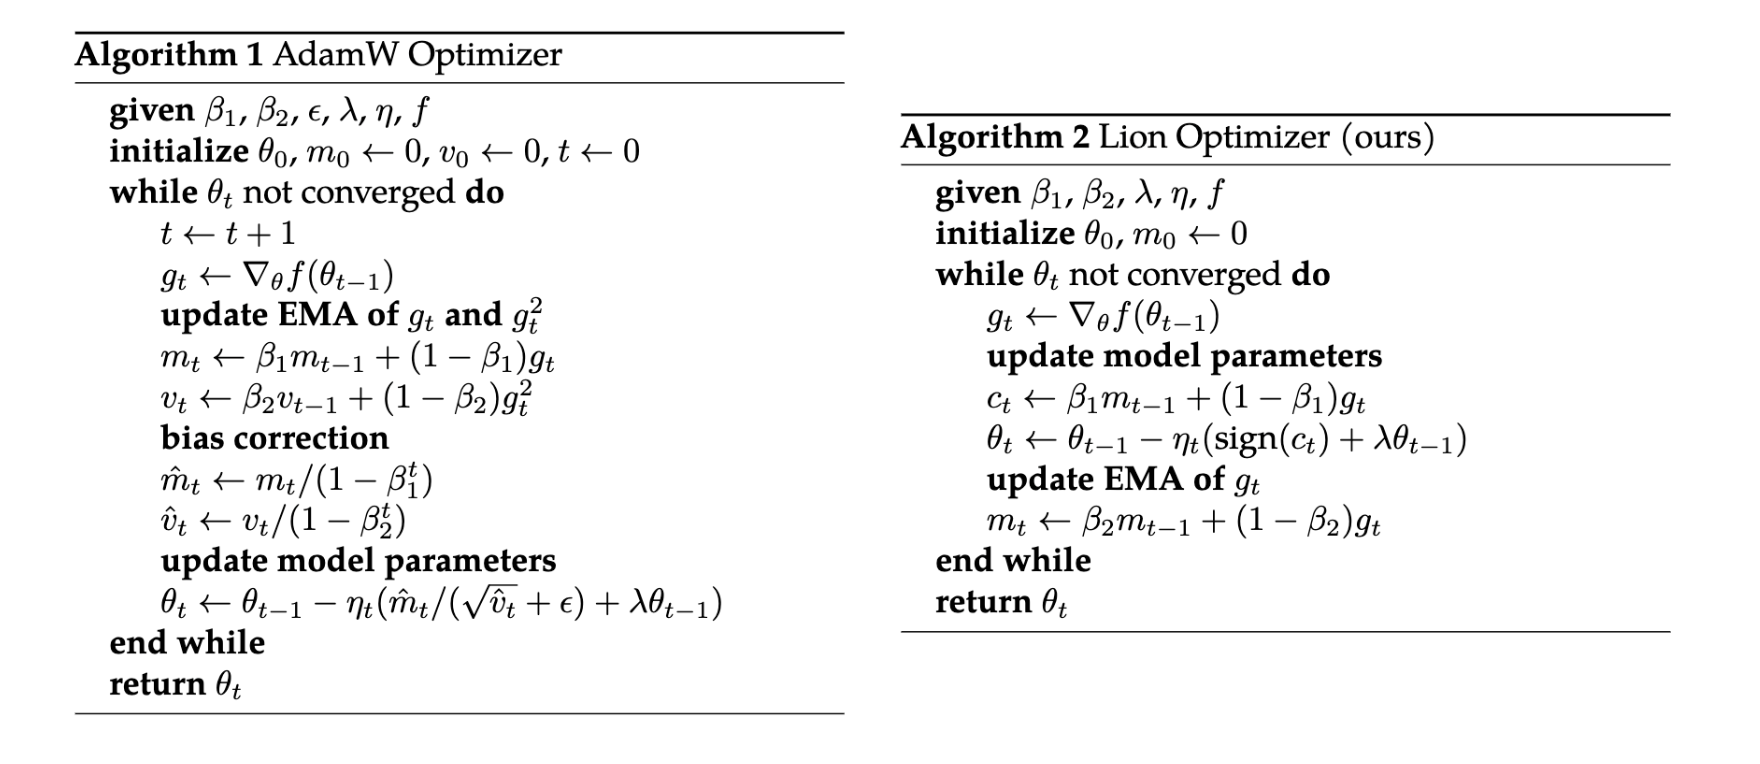

In [2]:
from typing import Any

import torch.optim
from torch.optim.optimizer import ParamsT

import numpy as np

In [3]:
def interp(x, y, a):
  return (1 - a) * x + a * y

In [21]:
class Lion(torch.optim.Optimizer):
    def __init__(
            self,
            params: ParamsT,
            lr: float = 1e-4,
            beta1: float = 0.9, beta2: float = 0.999,
            weight_decay: float = 0.0,
    ):
        default_params = {
            'lr': lr,
            'beta1': beta1,
            'beta2': beta2,
            'weight_decay': weight_decay
        }
        super().__init__(params, default_params)

    def _do_weight_decay(self, param_group: dict[str, Any]):
        pass
        # wd = param_group['weight_decay']
        # if wd == 0:
        #     return

        # for param in param_group['params']:
        #     if param.grad is not None:
        #         param.grad.add_(wd * param)

    def _update_states_for_param_group(self, param_group: dict[str, Any]):
        beta1 = param_group['beta1']
        beta2 = param_group['beta2']

        for param in param_group['params']:
            if param.grad is not None:
                state = self.state[param]

                #     update = interp(gradient, momentum, β1) momentum = m0
                #     update = np.sign(update)
                #     momentum = interp(gradient, momentum, β2)

                if 'm0' not in state:
                    state['m0'] = torch.zeros_like(param.grad)

                update = beta1 * state['m0'] + (1 - beta1) * param.grad
                update = torch.sign(update)

                state['m0'] = beta2 * state['m0'] + (1 - beta2) * param.grad
                state['update'] = update

    def _update_weights(self, param_group: dict[str, Any]):
        lr = param_group['lr']

        wd = param_group['weight_decay']

        for param in param_group['params']:
            if param.grad is not None:
                state = self.state[param]
                update = state['update']
                #     update = update + weight_decay
                #     update = update * lr

                update = update + wd * param
                update_by = - lr * (update)
                param.add_(update_by)

    @torch.no_grad()
    def step(self, closure = None):
        for param_group in self.param_groups:
            # self._do_weight_decay(param_group)
            self._update_states_for_param_group(param_group)
            self._update_weights(param_group)

## Оптимизатор готовый

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [6]:
from pathlib import Path

import pandas as pd
import torch
from torch import Tensor

_PERSON_INCOME_MAP = {
    'MORTGAGE': 0,
    'RENT': 1,
    'OWN': 2,
    'OTHER': 3
}

_LOAN_NTENT_MAP = {
    'EDUCATION': 0,
    'MEDICAL': 1,
    'VENTURE': 2,
    'PERSONAL': 3,
    'DEBTCONSOLIDATION': 4,
    'HOMEIMPROVEMENT': 5
}

_LOAN_GRADE_MAP = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6
}

_CB_FILE_MAP = {
    'N': 0,
    'Y': 1
}

class LoanDataset(Dataset):
    def __init__(self, data: pd.DataFrame):
        self._data = data

    def __len__(self):
        return len(self._data)

    def __getitem__(self, item: int) -> dict[str, dict[str | Tensor] | Tensor]:
        item = self._data.iloc[item]
        return {
            'target': torch.scalar_tensor(item['loan_status'], dtype=torch.float32),
            'cat_features': {
                'person_home_ownership': torch.scalar_tensor(_PERSON_INCOME_MAP[item['person_home_ownership']], dtype=torch.long),
                'loan_intent': torch.scalar_tensor(_LOAN_NTENT_MAP[item['loan_intent']], dtype=torch.long),
                'loan_grade': torch.scalar_tensor(_LOAN_GRADE_MAP[item['loan_grade']], dtype=torch.long),
                'cb_person_default_on_file': torch.scalar_tensor(_CB_FILE_MAP[item['cb_person_default_on_file']], dtype=torch.long)
            },
            'numeric_features': {
                'person_age': torch.scalar_tensor(-1 if pd.isna(item['person_age']) else (item['person_age'] / 123), dtype=torch.float32),
                'person_income': torch.scalar_tensor(-1 if pd.isna(item['person_income']) else (item['person_income'] / 1200000), dtype=torch.float32),
                'person_emp_length': torch.scalar_tensor(-1 if pd.isna(item['person_emp_length']) else (item['person_emp_length'] / 123), dtype=torch.float32),
                'loan_amnt': torch.scalar_tensor(-1 if pd.isna(item['loan_amnt']) else (item['loan_amnt'] / 35000), dtype=torch.float32),
                'loan_int_rate': torch.scalar_tensor(-1 if pd.isna(item['loan_int_rate']) else (item['loan_int_rate'] / 23.22), dtype=torch.float32),
                'loan_percent_income': torch.scalar_tensor(-1 if pd.isna(item['loan_percent_income']) else (item['loan_percent_income']), dtype=torch.float32),
                'cb_person_cred_hist_length': torch.scalar_tensor(-1 if pd.isna(item['cb_person_cred_hist_length']) else (item['cb_person_cred_hist_length'] / 30), dtype=torch.float32)
            }
        }


class LoanCollator:
    def __call__(self, items: list[dict[str, dict[str | Tensor] | Tensor]]) -> dict[str, dict[str | Tensor] | Tensor]:
        return {
            'target': torch.stack([x['target'] for x in items]),
            'cat_features': {
                'person_home_ownership': torch.stack([x['cat_features']['person_home_ownership'] for x in items]),
                'loan_intent': torch.stack([x['cat_features']['loan_intent'] for x in items]),
                'loan_grade': torch.stack([x['cat_features']['loan_grade'] for x in items]),
                'cb_person_default_on_file': torch.stack([x['cat_features']['cb_person_default_on_file'] for x in items])
            },
            'numeric_features': {
                'person_age': torch.stack([x['numeric_features']['person_age'] for x in items]),
                'person_income': torch.stack([x['numeric_features']['person_income'] for x in items]),
                'person_emp_length': torch.stack([x['numeric_features']['person_emp_length'] for x in items]),
                'loan_amnt': torch.stack([x['numeric_features']['loan_amnt'] for x in items]),
                'loan_int_rate': torch.stack([x['numeric_features']['loan_int_rate'] for x in items]),
                'loan_percent_income': torch.stack([x['numeric_features']['loan_percent_income'] for x in items]),
                'cb_person_cred_hist_length': torch.stack([x['numeric_features']['cb_person_cred_hist_length'] for x in items])
            }
        }


def load_loandata() -> tuple[LoanDataset, LoanDataset]:
    df_train = pd.read_csv('data/loan_train.csv')
    df_test = pd.read_csv('data/loan_test.csv')
    return LoanDataset(df_train), LoanDataset(df_test)

In [7]:
def _map_to_device(batch: dict, dev: torch.device) -> dict:
    batch['target'] = batch['target'].to(dev)

    batch['cat_features']['person_home_ownership'] = batch['cat_features']['person_home_ownership'].to(dev)
    batch['cat_features']['loan_intent'] = batch['cat_features']['loan_intent'].to(dev)
    batch['cat_features']['loan_grade'] = batch['cat_features']['loan_grade'].to(dev)
    batch['cat_features']['cb_person_default_on_file'] = batch['cat_features']['cb_person_default_on_file'].to(dev)

    batch['numeric_features']['person_age'] = batch['numeric_features']['person_age'].to(dev)
    batch['numeric_features']['person_income'] = batch['numeric_features']['person_income'].to(dev)
    batch['numeric_features']['person_emp_length'] = batch['numeric_features']['person_emp_length'].to(dev)
    batch['numeric_features']['loan_amnt'] = batch['numeric_features']['loan_amnt'].to(dev)
    batch['numeric_features']['loan_int_rate'] = batch['numeric_features']['loan_int_rate'].to(dev)
    batch['numeric_features']['loan_percent_income'] = batch['numeric_features']['loan_percent_income'].to(dev)
    batch['numeric_features']['cb_person_cred_hist_length'] = batch['numeric_features']['cb_person_cred_hist_length'].to(dev)

In [11]:
# pip install aim

In [15]:
from pathlib import Path

import torch
from aim import Run
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC
from tqdm import tqdm

def train(train_dataset, eval_dataset, model_name,
          base_hidden_size, n_epochs, base_dropout_p=0.0,
          base_weight_decay=0.01, base_lr=0.01):

    train_losses = []
    eval_losses = []
    train_roc_auc_values = []
    eval_roc_auc_values = []

    dev = torch.device('cuda:0')
    lr = base_lr
    batch_size = 32
    seed = 42
    weight_decay = base_weight_decay

    torch.random.manual_seed(seed)

    loss_bce = BCEWithLogitsLoss()

    collator = LoanCollator()
    model =  model_name(hidden_size=base_hidden_size, dropout_p=base_dropout_p).to(dev)
    optimizer = SGD(model.parameters(), lr=lr, weight_decay=weight_decay)

    run = Run(experiment='123')
    run["hparams"] = {
        "learning_rate": lr,
        "base_hidden_size": base_hidden_size,
        "batch_size": batch_size,
        'weight_decay': weight_decay
    }

    train_dl = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)
    eval_dl = DataLoader(eval_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)

    for i_epoch in tqdm(range(n_epochs)):
        train_loss = MeanMetric().to(dev)
        train_rocauc = AUROC(task='binary').to(dev)

        for i, batch in enumerate(train_dl):
            _map_to_device(batch, dev)

            result = model(cat_features=batch['cat_features'], numeric_features=batch['numeric_features'])
            loss_value = loss_bce(result, batch['target'])
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), batch['target'])

        train_loss_value = train_loss.compute().item()
        train_rocauc_value = train_rocauc.compute().item()
        train_losses.append(train_loss_value)
        train_roc_auc_values.append(train_rocauc_value)
        run.track(train_loss_value, name='loss/train', step=i_epoch)
        run.track(train_rocauc_value, name='roc-auc/train', step=i_epoch)

        eval_loss = MeanMetric().to(dev)
        eval_rocauc = AUROC(task='binary').to(dev)

        model.eval()
        with torch.no_grad():
            for i_eval, batch_eval in enumerate(eval_dl):
                _map_to_device(batch_eval, dev)

                result_eval = model(cat_features=batch_eval['cat_features'], numeric_features=batch_eval['numeric_features'])
                eval_loss_value = loss_bce(result_eval, batch_eval['target'])

                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval), batch_eval['target'])

        eval_loss_value = eval_loss.compute().item()
        eval_rocauc_value = eval_rocauc.compute().item()
        eval_losses.append(eval_loss_value)
        eval_roc_auc_values.append(eval_rocauc_value)
        run.track(eval_loss_value, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc_value, name='roc-auc/eval', step=i_epoch)

        model.train()

        eval_loss = eval_loss.compute().item()
        eval_rocauc = eval_rocauc.compute().item()
        run.track(eval_loss, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc, name='roc-auc/eval', step=i_epoch)

        print(f'Epoch {i_epoch+1}/{n_epochs}, Train Loss: {train_loss_value:.4f}, Test Loss: {eval_loss_value:.4f}, '
              f'Train ROC-AUC: {train_rocauc_value:.4f}, Test ROC-AUC: {eval_rocauc_value:.4f}')

    return {'train_losses': train_losses,
            'eval_losses': eval_losses,
            'train_roc_auc_values': train_roc_auc_values,
            'eval_roc_auc_values': eval_roc_auc_values}

In [14]:
# pip install torchmetrics

In [16]:
def func_subplots(dict):
    train_losses = dict['train_losses']
    eval_losses = dict['eval_losses']
    train_roc_auc_values = dict['train_roc_auc_values']
    eval_roc_auc_values = dict['eval_roc_auc_values']

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue', marker='o')
    axs[0].plot(range(1, len(eval_losses) + 1), eval_losses, label='Eval Loss', color='orange', marker='o')
    axs[0].set_title('Loss')

    axs[1].plot(range(1, len(train_roc_auc_values) + 1), train_roc_auc_values, label='Train ROC-AUC', color='blue', marker='o')
    axs[1].plot(range(1, len(eval_roc_auc_values) + 1), eval_roc_auc_values, label='Eval ROC-AUC', color='orange', marker='o')
    axs[1].set_title('ROC-AUC')

    for i in range(2):
      axs[i].set_xlabel('Epochs')
      axs[i].set_ylabel('Value')
      axs[i].legend()
      axs[i].grid()

In [17]:
class FirstModel(nn.Module):
    def __init__(self, hidden_size=32, dropout_p=0.0):
        super().__init__()

        self.emb_person_home_ownership = nn.Embedding(4, embedding_dim=hidden_size)
        self.emb_loan_intent = nn.Embedding(6, embedding_dim=hidden_size)
        self.emb_loan_grade = nn.Embedding(7, embedding_dim=hidden_size)
        self.emb_cb_person_default_on_file = nn.Embedding(2, embedding_dim=hidden_size)

        self.numeric_linear = nn.Linear(7, hidden_size)

        self.block = nn.Sequential(
            nn.Linear(hidden_size, hidden_size*4),
            nn.ReLU(),
            nn.Linear(hidden_size*4, hidden_size)
        )

        self.linear_out = nn.Linear(hidden_size, 1)

    def forward(self, cat_features: dict[str, Tensor], numeric_features: dict[str, Tensor]) -> Tensor:
        x_person_home_ownership = self.emb_person_home_ownership(cat_features['person_home_ownership'])
        x_loan_intent = self.emb_loan_intent(cat_features['loan_intent'])
        x_loan_grade = self.emb_loan_grade(cat_features['loan_grade'])
        x_cb_person_default_on_file = self.emb_cb_person_default_on_file(cat_features['cb_person_default_on_file'])

        stacked_numeric = torch.stack([numeric_features['person_age'],
                                       numeric_features['person_income'],
                                       numeric_features['person_emp_length'],
                                       numeric_features['loan_amnt'],
                                       numeric_features['loan_int_rate'],
                                       numeric_features['loan_percent_income'],
                                       numeric_features['cb_person_cred_hist_length']
                                       ], dim=-1)

        x_numeric = self.numeric_linear(stacked_numeric)
        x = x_person_home_ownership + x_loan_intent + x_loan_grade + x_cb_person_default_on_file + x_numeric

        x = self.block(x)
        x = self.linear_out(x)
        return x.squeeze(-1)

# Итог

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  5%|▌         | 1/20 [00:22<07:16, 22.96s/it]

Epoch 1/20, Train Loss: 0.3156, Test Loss: 0.2921, Train ROC-AUC: 0.8145, Test ROC-AUC: 0.8474


 10%|█         | 2/20 [00:46<06:58, 23.28s/it]

Epoch 2/20, Train Loss: 0.2917, Test Loss: 0.2852, Train ROC-AUC: 0.8419, Test ROC-AUC: 0.8559


 15%|█▌        | 3/20 [01:10<06:45, 23.83s/it]

Epoch 3/20, Train Loss: 0.2864, Test Loss: 0.2808, Train ROC-AUC: 0.8509, Test ROC-AUC: 0.8640


 20%|██        | 4/20 [01:34<06:20, 23.75s/it]

Epoch 4/20, Train Loss: 0.2822, Test Loss: 0.2768, Train ROC-AUC: 0.8587, Test ROC-AUC: 0.8711


 25%|██▌       | 5/20 [01:58<05:55, 23.72s/it]

Epoch 5/20, Train Loss: 0.2782, Test Loss: 0.2725, Train ROC-AUC: 0.8661, Test ROC-AUC: 0.8783


 30%|███       | 6/20 [02:22<05:32, 23.74s/it]

Epoch 6/20, Train Loss: 0.2739, Test Loss: 0.2679, Train ROC-AUC: 0.8734, Test ROC-AUC: 0.8849


 35%|███▌      | 7/20 [02:45<05:07, 23.67s/it]

Epoch 7/20, Train Loss: 0.2695, Test Loss: 0.2632, Train ROC-AUC: 0.8794, Test ROC-AUC: 0.8901


 40%|████      | 8/20 [03:08<04:41, 23.50s/it]

Epoch 8/20, Train Loss: 0.2654, Test Loss: 0.2588, Train ROC-AUC: 0.8839, Test ROC-AUC: 0.8941


 45%|████▌     | 9/20 [03:32<04:20, 23.64s/it]

Epoch 9/20, Train Loss: 0.2614, Test Loss: 0.2547, Train ROC-AUC: 0.8873, Test ROC-AUC: 0.8971


 50%|█████     | 10/20 [03:56<03:57, 23.72s/it]

Epoch 10/20, Train Loss: 0.2581, Test Loss: 0.2514, Train ROC-AUC: 0.8898, Test ROC-AUC: 0.8994


 55%|█████▌    | 11/20 [04:20<03:34, 23.79s/it]

Epoch 11/20, Train Loss: 0.2552, Test Loss: 0.2487, Train ROC-AUC: 0.8917, Test ROC-AUC: 0.9012


 60%|██████    | 12/20 [04:47<03:19, 24.88s/it]

Epoch 12/20, Train Loss: 0.2529, Test Loss: 0.2465, Train ROC-AUC: 0.8932, Test ROC-AUC: 0.9026


 65%|██████▌   | 13/20 [05:11<02:51, 24.56s/it]

Epoch 13/20, Train Loss: 0.2510, Test Loss: 0.2446, Train ROC-AUC: 0.8944, Test ROC-AUC: 0.9037


 70%|███████   | 14/20 [05:36<02:28, 24.69s/it]

Epoch 14/20, Train Loss: 0.2496, Test Loss: 0.2432, Train ROC-AUC: 0.8952, Test ROC-AUC: 0.9046


 75%|███████▌  | 15/20 [06:00<02:02, 24.49s/it]

Epoch 15/20, Train Loss: 0.2485, Test Loss: 0.2423, Train ROC-AUC: 0.8958, Test ROC-AUC: 0.9052


 80%|████████  | 16/20 [06:24<01:37, 24.28s/it]

Epoch 16/20, Train Loss: 0.2478, Test Loss: 0.2417, Train ROC-AUC: 0.8961, Test ROC-AUC: 0.9057


 85%|████████▌ | 17/20 [06:48<01:12, 24.32s/it]

Epoch 17/20, Train Loss: 0.2474, Test Loss: 0.2412, Train ROC-AUC: 0.8963, Test ROC-AUC: 0.9060


 90%|█████████ | 18/20 [07:13<00:48, 24.34s/it]

Epoch 18/20, Train Loss: 0.2471, Test Loss: 0.2410, Train ROC-AUC: 0.8964, Test ROC-AUC: 0.9061


 95%|█████████▌| 19/20 [07:36<00:24, 24.13s/it]

Epoch 19/20, Train Loss: 0.2471, Test Loss: 0.2410, Train ROC-AUC: 0.8964, Test ROC-AUC: 0.9061


100%|██████████| 20/20 [08:00<00:00, 24.01s/it]

Epoch 20/20, Train Loss: 0.2471, Test Loss: 0.2410, Train ROC-AUC: 0.8964, Test ROC-AUC: 0.9061


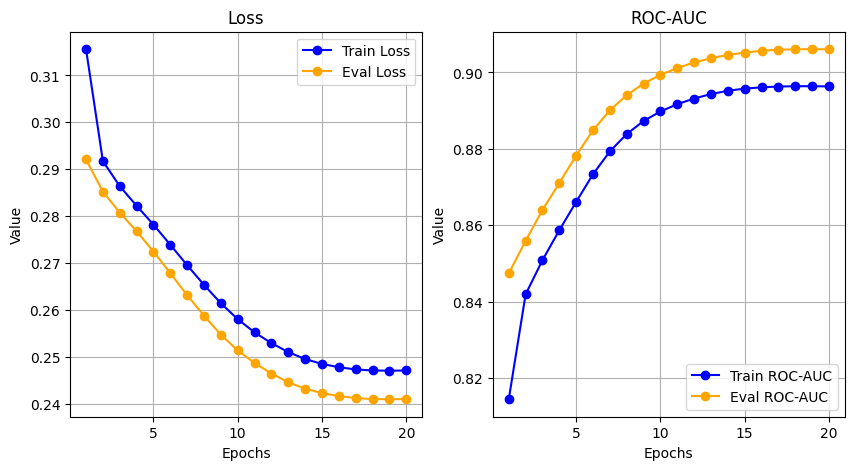

In [18]:
train_ds_1, test_ds_1 = load_loandata()
dict_sub_1 = train(train_ds_1, test_ds_1,
                 model_name = FirstModel,
                 base_hidden_size = 32,
                 n_epochs = 20)
func_subplots(dict_sub_1)

# Lion

In [26]:
from pathlib import Path

import torch
from aim import Run
from torch.nn import BCEWithLogitsLoss
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader
from torchmetrics import MeanMetric, AUROC
from tqdm import tqdm

def trainLion(train_dataset, eval_dataset, model_name,
          base_hidden_size, n_epochs, base_dropout_p=0.0,
          base_weight_decay=0.01, base_lr=0.01):

    train_losses = []
    eval_losses = []
    train_roc_auc_values = []
    eval_roc_auc_values = []

    dev = torch.device('cuda:0')
    lr = base_lr
    batch_size = 32
    seed = 42
    weight_decay = base_weight_decay

    torch.random.manual_seed(seed)

    loss_bce = BCEWithLogitsLoss()

    collator = LoanCollator()
    model =  model_name(hidden_size=base_hidden_size, dropout_p=base_dropout_p).to(dev)
    optimizer = Lion(params=model.parameters())

    run = Run(experiment='123')
    run["hparams"] = {
        "learning_rate": lr,
        "base_hidden_size": base_hidden_size,
        "batch_size": batch_size,
        'weight_decay': weight_decay
    }

    train_dl = DataLoader(train_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)
    eval_dl = DataLoader(eval_dataset, batch_size=batch_size, num_workers=8, collate_fn=collator, pin_memory=True)

    for i_epoch in tqdm(range(n_epochs)):
        train_loss = MeanMetric().to(dev)
        train_rocauc = AUROC(task='binary').to(dev)

        for i, batch in enumerate(train_dl):
            _map_to_device(batch, dev)

            result = model(cat_features=batch['cat_features'], numeric_features=batch['numeric_features'])
            loss_value = loss_bce(result, batch['target'])
            loss_value.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss.update(loss_value)
            train_rocauc.update(torch.sigmoid(result), batch['target'])

        train_loss_value = train_loss.compute().item()
        train_rocauc_value = train_rocauc.compute().item()
        train_losses.append(train_loss_value)
        train_roc_auc_values.append(train_rocauc_value)
        run.track(train_loss_value, name='loss/train', step=i_epoch)
        run.track(train_rocauc_value, name='roc-auc/train', step=i_epoch)

        eval_loss = MeanMetric().to(dev)
        eval_rocauc = AUROC(task='binary').to(dev)

        model.eval()
        with torch.no_grad():
            for i_eval, batch_eval in enumerate(eval_dl):
                _map_to_device(batch_eval, dev)

                result_eval = model(cat_features=batch_eval['cat_features'], numeric_features=batch_eval['numeric_features'])
                eval_loss_value = loss_bce(result_eval, batch_eval['target'])

                eval_loss.update(eval_loss_value)
                eval_rocauc.update(torch.sigmoid(result_eval), batch_eval['target'])

        eval_loss_value = eval_loss.compute().item()
        eval_rocauc_value = eval_rocauc.compute().item()
        eval_losses.append(eval_loss_value)
        eval_roc_auc_values.append(eval_rocauc_value)
        run.track(eval_loss_value, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc_value, name='roc-auc/eval', step=i_epoch)

        model.train()

        eval_loss = eval_loss.compute().item()
        eval_rocauc = eval_rocauc.compute().item()
        run.track(eval_loss, name='loss/eval', step=i_epoch)
        run.track(eval_rocauc, name='roc-auc/eval', step=i_epoch)

        print(f'Epoch {i_epoch+1}/{n_epochs}, Train Loss: {train_loss_value:.4f}, Test Loss: {eval_loss_value:.4f}, '
              f'Train ROC-AUC: {train_rocauc_value:.4f}, Test ROC-AUC: {eval_rocauc_value:.4f}')

    return {'train_losses': train_losses,
            'eval_losses': eval_losses,
            'train_roc_auc_values': train_roc_auc_values,
            'eval_roc_auc_values': eval_roc_auc_values}

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
  5%|▌         | 1/20 [00:28<09:04, 28.68s/it]

Epoch 1/20, Train Loss: 0.3119, Test Loss: 0.2720, Train ROC-AUC: 0.8182, Test ROC-AUC: 0.8703


 10%|█         | 2/20 [00:55<08:17, 27.62s/it]

Epoch 2/20, Train Loss: 0.2626, Test Loss: 0.2429, Train ROC-AUC: 0.8823, Test ROC-AUC: 0.8998


 15%|█▌        | 3/20 [01:22<07:44, 27.33s/it]

Epoch 3/20, Train Loss: 0.2376, Test Loss: 0.2213, Train ROC-AUC: 0.8977, Test ROC-AUC: 0.9115


 20%|██        | 4/20 [01:49<07:13, 27.10s/it]

Epoch 4/20, Train Loss: 0.2203, Test Loss: 0.2076, Train ROC-AUC: 0.9083, Test ROC-AUC: 0.9187


 25%|██▌       | 5/20 [02:16<06:44, 26.96s/it]

Epoch 5/20, Train Loss: 0.2123, Test Loss: 0.2036, Train ROC-AUC: 0.9133, Test ROC-AUC: 0.9217


 30%|███       | 6/20 [02:42<06:17, 26.94s/it]

Epoch 6/20, Train Loss: 0.2101, Test Loss: 0.2017, Train ROC-AUC: 0.9149, Test ROC-AUC: 0.9228


 35%|███▌      | 7/20 [03:09<05:49, 26.85s/it]

Epoch 7/20, Train Loss: 0.2079, Test Loss: 0.1993, Train ROC-AUC: 0.9162, Test ROC-AUC: 0.9239


 40%|████      | 8/20 [03:36<05:21, 26.77s/it]

Epoch 8/20, Train Loss: 0.2053, Test Loss: 0.1983, Train ROC-AUC: 0.9175, Test ROC-AUC: 0.9234


 45%|████▌     | 9/20 [04:02<04:53, 26.72s/it]

Epoch 9/20, Train Loss: 0.2031, Test Loss: 0.1940, Train ROC-AUC: 0.9189, Test ROC-AUC: 0.9270


 50%|█████     | 10/20 [04:30<04:29, 26.93s/it]

Epoch 10/20, Train Loss: 0.2002, Test Loss: 0.1915, Train ROC-AUC: 0.9206, Test ROC-AUC: 0.9285


 55%|█████▌    | 11/20 [04:57<04:02, 26.93s/it]

Epoch 11/20, Train Loss: 0.1982, Test Loss: 0.1894, Train ROC-AUC: 0.9222, Test ROC-AUC: 0.9297


 60%|██████    | 12/20 [05:28<03:47, 28.39s/it]

Epoch 12/20, Train Loss: 0.1966, Test Loss: 0.1884, Train ROC-AUC: 0.9234, Test ROC-AUC: 0.9299


 65%|██████▌   | 13/20 [05:55<03:15, 27.96s/it]

Epoch 13/20, Train Loss: 0.1957, Test Loss: 0.1876, Train ROC-AUC: 0.9240, Test ROC-AUC: 0.9300


 70%|███████   | 14/20 [06:23<02:46, 27.74s/it]

Epoch 14/20, Train Loss: 0.1949, Test Loss: 0.1863, Train ROC-AUC: 0.9244, Test ROC-AUC: 0.9311


 75%|███████▌  | 15/20 [06:50<02:18, 27.68s/it]

Epoch 15/20, Train Loss: 0.1941, Test Loss: 0.1855, Train ROC-AUC: 0.9249, Test ROC-AUC: 0.9318


 80%|████████  | 16/20 [07:17<01:49, 27.40s/it]

Epoch 16/20, Train Loss: 0.1935, Test Loss: 0.1850, Train ROC-AUC: 0.9252, Test ROC-AUC: 0.9320


 85%|████████▌ | 17/20 [07:44<01:21, 27.27s/it]

Epoch 17/20, Train Loss: 0.1931, Test Loss: 0.1849, Train ROC-AUC: 0.9253, Test ROC-AUC: 0.9319


 90%|█████████ | 18/20 [08:11<00:54, 27.15s/it]

Epoch 18/20, Train Loss: 0.1926, Test Loss: 0.1843, Train ROC-AUC: 0.9257, Test ROC-AUC: 0.9324


 95%|█████████▌| 19/20 [08:38<00:27, 27.08s/it]

Epoch 19/20, Train Loss: 0.1920, Test Loss: 0.1838, Train ROC-AUC: 0.9259, Test ROC-AUC: 0.9327


100%|██████████| 20/20 [09:04<00:00, 27.24s/it]

Epoch 20/20, Train Loss: 0.1915, Test Loss: 0.1837, Train ROC-AUC: 0.9262, Test ROC-AUC: 0.9325


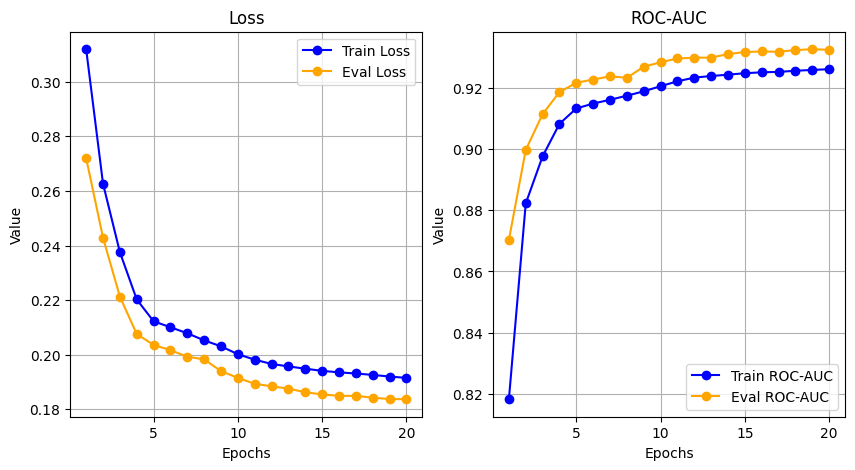

In [29]:
train_ds_2, test_ds_2 = load_loandata()
dict_sub_2 = trainLion(train_ds_2, test_ds_2,
                 model_name = FirstModel,
                 base_hidden_size = 32,
                 n_epochs = 20)
func_subplots(dict_sub_2)